<a href="https://colab.research.google.com/github/weiyw16/Seismic_Tools/blob/master/tutorial_conv_reflectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seismic images forward through convolution between wavelet and reflectivity

Author: Yanwen Wei \
Email: weiyw17@gmail.com



---


Take away points:  \
```
from scipy import signal
migraion_image = signal.convolve(wavelet, reflectivity, mode = 'same')
```


In [1]:
# requirement
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import interpolate


In [2]:
def smooth_interface(n_layers=None, model_interface=None, xnew=None, ynew=None, well_loc=None):
    '''
    model_interface: [n_layers-1, nspace]
    
    '''
    modely_gra = np.zeros((n_layers, xnew.shape[0])  )
    new_modely = np.zeros((ynew.shape[0], xnew.shape[0])  ) 
    slight = np.zeros((ynew.shape[0], xnew.shape[0])  )
    for i in range(xnew.shape[0]): # 801
        modely_gra[:,i] =  model_interface[:,i] - model_interface[:,well_loc]
        y = ( interpolate.interp1d(model_interface[:,well_loc], modely_gra[:,i], \
                                   kind='linear', fill_value="extrapolate" ) )
        slight[:, i] = y(ynew) 
        new_modely[:, i] = ynew + slight[:, i]
    return slight, new_modely

In [3]:
# self defined Ricker wavelet
# not use in this tutorial
def dricker(freq=None, T=None, dt=None):
    t = np.linspace(0, T, dt)
    t = t - 1.5 / freq
    a = freq * sqrt(2) * pi
    wave = (1 - a*a*t*t)*exp(-0.5*a*a*t*t)
    wave = wave*amp0
    return wave

## 1. produce a Ricker wavelet

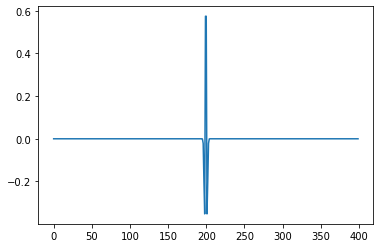

In [4]:
# ricker wavelet via signal.ricker
kers = 400
points = kers
Amplitude = 1.0
vec2 = signal.ricker(points, Amplitude)
plt.plot(vec2)


## 2. produce reflectivity
(load in demo relectivity if available)


In [33]:
## product velocity model
# note that the dimension should be [nx, nz] to make nz the fast axis

# parameters
nz = kers; nx = 126
n_layers = 3; well_loc = 60
tao = 30; k = 2.7

# build reflectivity

x = np.arange(0, nx, 1); xnew = x
y = np.arange(0, nz, 1); ynew = y
intef0 = x * 0
intef = x * k + tao
intef1 = x * 0 + y[-1]

model_interface = np.concatenate( (np.expand_dims(intef0,axis=0), np.expand_dims(intef,axis=0), np.expand_dims(intef1,axis=0)), axis=0)
slight, new_modely = smooth_interface(n_layers=n_layers, model_interface=model_interface, xnew=xnew, ynew=ynew, well_loc=well_loc)

# build velocity
mdlpa = [100, 200] # P velocity 
## prepare the velocity in the well
model_1d = np.zeros( nz, dtype=np.float32 )
for iy in range(nz):
    for index in range(n_layers - 1):
        if iy <= model_interface[index+1, well_loc]:
            model_1d[iy] = mdlpa[index]
            break
# model[-1] = mdlpa[-1]

# expand velocity from well to 2D
model_2d = np.zeros((nz, nx), dtype=np.float32 )
for ix in range(nx):
    y = ( interpolate.interp1d(new_modely[:, ix], model_1d, kind='linear', fill_value="extrapolate" ) )
#     y = ( interpolate.interp1d(new_modely[:, ix], model, kind='cubic', fill_value="extrapolate" ) )
    model_2d[:, ix] = y(ynew) 

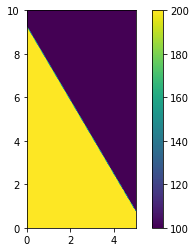

In [34]:
# plot velocity model
checkpoint = 1
if checkpoint:
    im = plt.imshow(model_2d, extent = [0, 5, 0, 10])
    plt.colorbar(im)

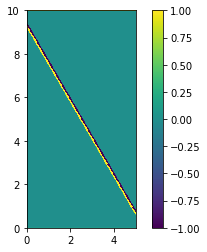

In [44]:
# convolution 
out_mig = np.zeros_like(model_2d)
for ii in range(nx):
    out_mig[:,ii] = signal.convolve(vec2, model_2d[:,ii], mode = 'same')

# plot
# plt.imshow(out_mig[:-3,:], vmax=1, vmin=-1, extent = [0, 40, 0, 10])
plt.imshow(out_mig[3:-3,:], vmax=1, vmin=-1, extent = [0, 5, 0, 10])
plt.colorbar()